## Objective 

> Convolution Neural Network가 사물을 분류할 때, 어떤 요소를 파악하여 분류하는 지를 확인할 필요가 있습니다. 기본적으로 Deep Learning에서 다루는 모델들은 Black Box라는 특성을 띄고 있습니다. 내부의 동작이 어떤 식으로 이루어지는지 확인하기 어렵기 때문이죠. 이를 해소하기 위해, Convolution Neural Network의 동작을 확인하는 기법들이 생겨났고, 그 중 가장 대표적인 방법이 **Grad-CAM**입니다.


In [3]:
%matplotlib inline
import os
import shutil

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [4]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### [예제 이미지 : 강아지와 레서판다 ] 

이번에는 강아지와 레서판다 이미지를 통해, Neural Network가 어떤 식으로 판단하는지를 확인해보도록 하겠습니다.

In [5]:
# Cat VS Dog Dataset 가져오기
if not os.path.exists("./dog_and_cat.jpg"):
    !wget -q https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/dog_and_cat.jpg
if not os.path.exists("./redpanda.jpg"):
    !wget -q https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/redpanda.jpg

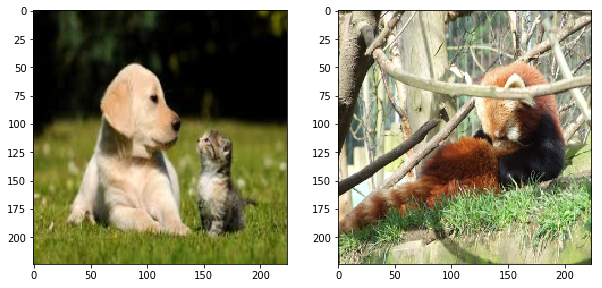

In [6]:
# 이미지 시각화하기 
dog_image = cv2.imread("./dog_and_cat.jpg")
dog_image = cv2.cvtColor(dog_image, cv2.COLOR_BGR2RGB)

dog_image = cv2.resize(dog_image, (224,224))

panda_image = cv2.imread("./redpanda.jpg")
panda_image = cv2.cvtColor(panda_image, cv2.COLOR_BGR2RGB)

panda_image = cv2.resize(panda_image, (224,224))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(dog_image)
ax = fig.add_subplot(1,2,2)
ax.imshow(panda_image)
plt.show()

우리가 알고 싶은 것은 
> 특정 클래스에 대한 출력값($y^c$)는 영상 속 어떤 부분 때문에 결정되었을까?

입니다.

CNN은 이미지에서 의미를 추출하는 Feature Extractor로서 기능하게 됩니다. <br>
CNN을 통해 추출된 Feature Map($A$)에는 각 Pixel의 위치 별로 사물의 특징에 대한 정보가 녹아져 있습니다.<br>

Feature Map은 $N_C$개, 즉 Channel 갯수 만큼의 각기 다른 특징들을 잡고 있습니다. <br> 

## 1. 기학습된 모델 가져오기

> Feature Map이 우선 어떤 식으로 생겼는지 시각화 해보도록 하겠ㅅ브니다.

In [8]:
import keras.backend as K
from keras.applications import VGG16
from keras.applications.vgg16 import decode_predictions

# 기학습된 모델 가져오기 
K.clear_session()

# Input Tensor 선언하기
inputs = tf.placeholder(tf.float32,shape=(None,224,224,3),name='inputs')
# VGG Neural Network의 경우, image mean값을 빼주는 전처리가 진행되었습니다.
pred_ = inputs - tf.constant([123.68,116.779,103.939])

vgg16 = VGG16(weights='imagenet',
              input_tensor=pred_,
              include_top=True)

# Session 가져오기
sess = K.get_session()
graph = sess.graph

In [9]:
show_graph(graph)

대표적인 VGG 모델은 Convolution Layer와 Pooling Layer가 서로 반복하면서 이어진 구조입니다. <br>
CNN은 Convolution layer가 반복되면서, 저차원의 정보에서 고차원의 정보로 바뀝니다.<br>
그렇기 때문에, 위의 모델에서 가장 고차원으로 된 정보는 `block5_conv3`의 출력값에 존재합니다.<br>

입력값이 Feature Map을 거쳐감에 따라, 어떤 식으로 바뀌는 지 확인해보도록 하겠습니다.



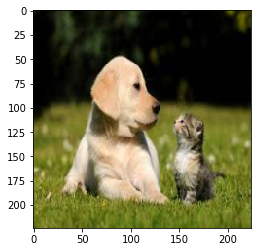

In [11]:
# 입력값의 이미지
plt.imshow(dog_image)
plt.show()

In [12]:
# VGG Convolution Layer의 마지막 Tensor 가져오기
conv1_1 = graph.get_tensor_by_name('block1_conv1/Relu:0')
conv2_2 = graph.get_tensor_by_name('block2_conv2/Relu:0')
conv5_3 = graph.get_tensor_by_name('block5_conv3/Relu:0')

# VGG Convolution Layer의 Feature Map 연산하기
hidden_first_outputs = sess.run(conv1_1[:,:,:,:25],
                          feed_dict={inputs:dog_image[np.newaxis]})[0]
hidden_first_outputs = hidden_first_outputs.transpose(2,0,1)

hidden_second_outputs = sess.run(conv2_2[:,:,:,:25],
                          feed_dict={inputs:dog_image[np.newaxis]})[0]
hidden_second_outputs = hidden_second_outputs.transpose(2,0,1)

hidden_final_outputs = sess.run(conv5_3[:,:,:,:25],
                          feed_dict={inputs:dog_image[np.newaxis]})[0]
hidden_final_outputs = hidden_final_outputs.transpose(2,0,1)

첫번째 Feature Map은 아래와 같은 형태를 띕니다. <br> 
저차원의 특징들을 뽑아내는데, 색에 대한 정보, 윤곽에 대한 정보 등 국소적인 특징들만 보고 뽑아냅니다.<br>

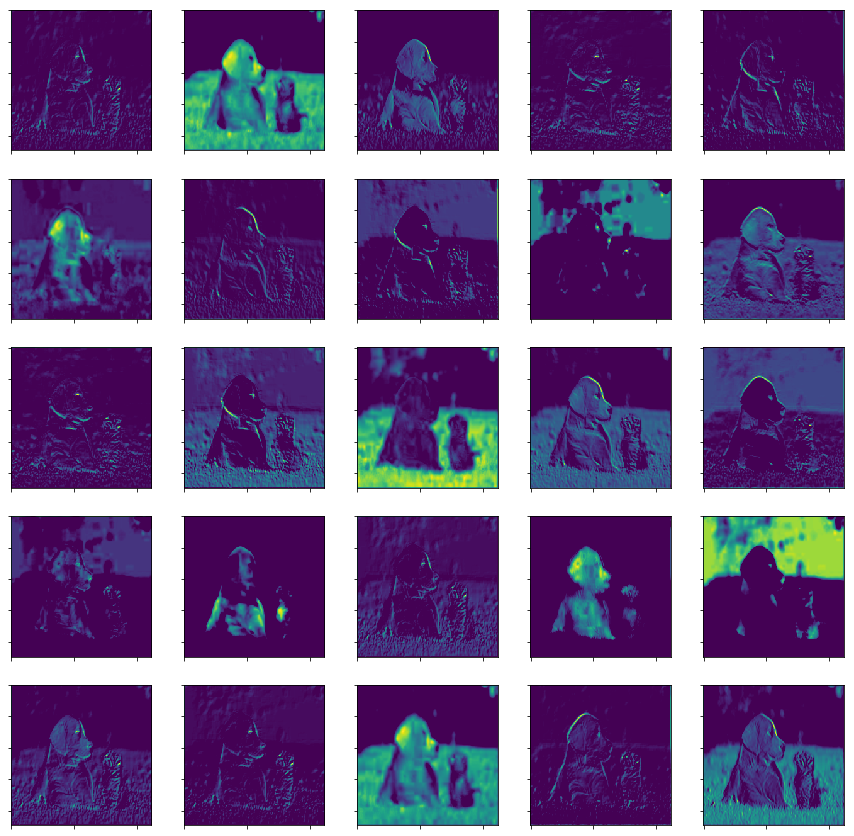

In [13]:
fig = plt.figure(figsize=(15,15))

num_filters = len(hidden_first_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_first_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

좀 더 고차원화된 층에서는 어떤 특징을 잡아낼까요? <br>
질감에 대한 정보, 면에 대한 정보, 곡선에 대한 정보등 좀더 복잡한 특징들을 잡습니다.<br>

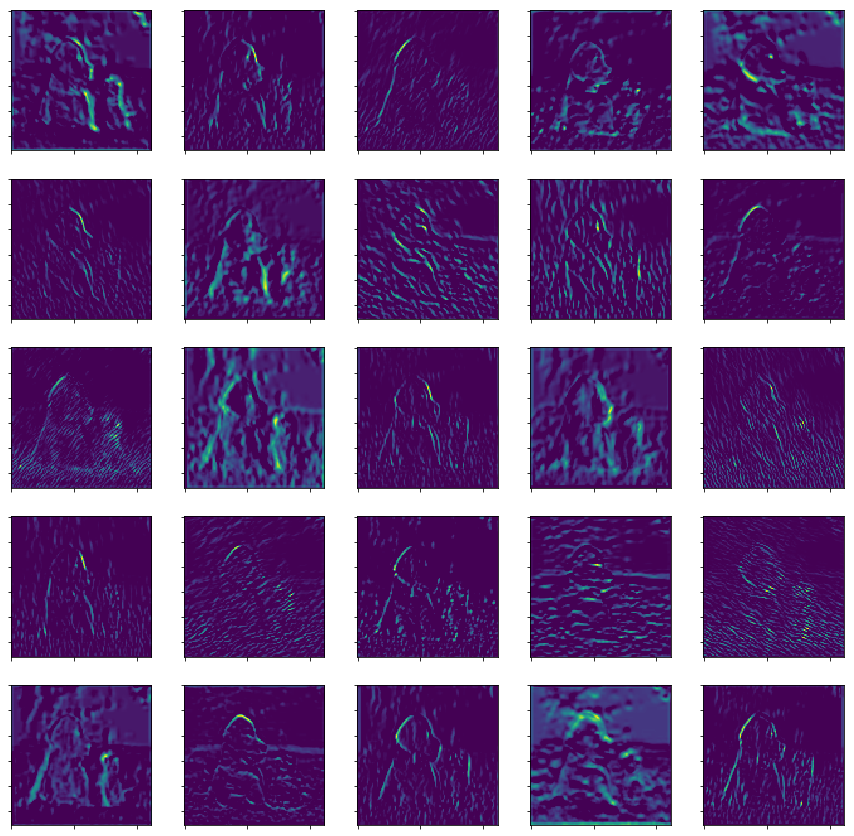

In [14]:
fig = plt.figure(figsize=(15,15))

num_filters = len(hidden_second_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_second_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

마지막 Feature Map은 어떤 형태를 띌까요?

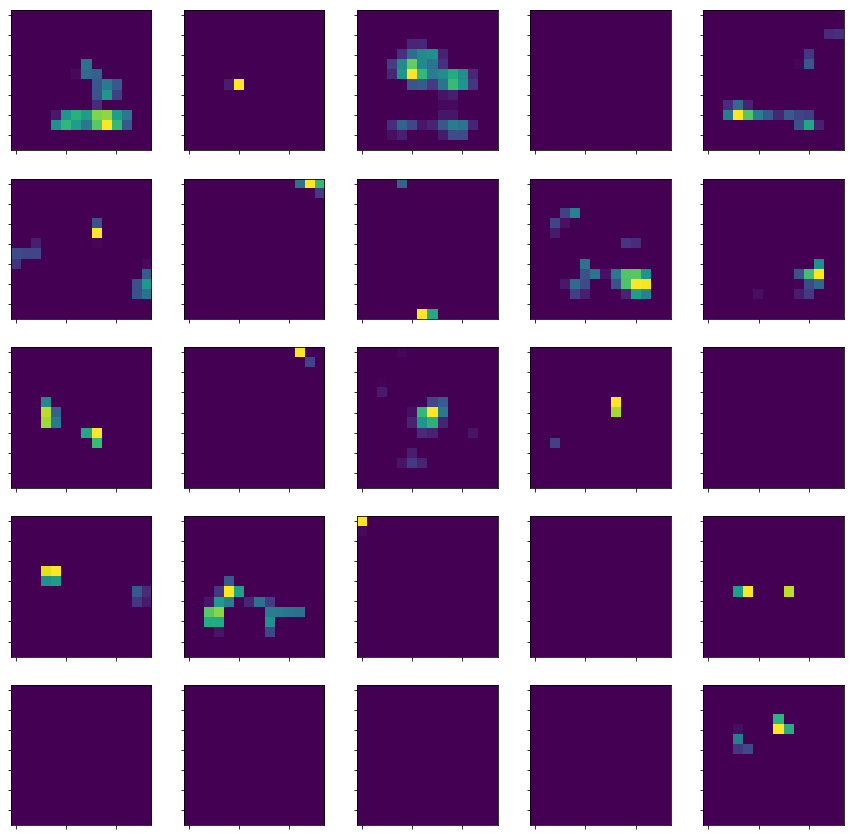

In [15]:
fig = plt.figure(figsize=(15,15))

num_filters = len(hidden_final_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_final_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

더 이상 우리는 해석하긴 어렵지만, 각 위치별로 고차원의 특징들이 잡혀있다고 생각할 수 있습니다.<br> 전체 위치에 딱 한점 혹은 크게 분포된 점들은 그 주위로 어떠한 이미지의 중요한 특징이 존재한다고 볼 수 있습니다.


Task-Specific network에서는 Feature Map을 통해, 우리가 원하는 

1. 사물을 분류하거나(Image Classification), 
2. 이미지를 설명하거나(Image Captioning),
3. 영상에 답을 달거나 (Visual Question Answering)

등을 수행할 것입니다.



## 1. CAM의 방식

---

우리가 궁금한 것은 Task-Specific network에서 Feature Map 중 어떤 Feature Map을 특히 중요하게 생각했을까 입니다. 처음에 Naive한 접근법은 바로 CAM 모델에서 나온 방식입니다.<br>

어떤 Feature Map이 중요한지 알도록 알기 쉽게 모델의 구조를 바꾸어 버리자! 입니다.

CAM 논문 속 이미지

![Imgur](https://i.imgur.com/NZgUIwe.png)

특정 Class의 판별은 Feature Map의 Linear Combination의 결과로 구성됩니다. <br>

하나의 Class에 대한 특정 Feature Map의 Weight가 크다는 것은 <br>
해당 Feature Map이 잡고 있는 특징 정보가 매우 중요하다는 것이고, 이를 통해 <br>
실제 이미지 속 중요한 특징 정보가 대강 어디에 있는지를 파악할 수 있게 됩니다.

## 2.  GradCAM의 방식

----

![Imgur](https://i.imgur.com/BqaK7V4.png)

CAM의 방식의 주된 문제는 

> 모델을 바꾸어야 한다. 

입니다. 모델이 저 형태가 아니면 쓸 수 없는 구조입니다. GradCAM 방식은 훨씬 더 General한 방법론으로<br> 모델이 어떻든 간에 쓸 수 있는 구조입니다.<br>

핵심 아이디어는 아래와 같습니다.

> 출력 클래스에 대한 Feature Map의 미분값($\frac{\partial y^c}{\partial A}$)은 출력 클래스에 대한 Feature Map의 중요도이다.

이것에 대한 엄밀한 수학적 증명은 없습니다만, 제 짧은 소견으로는 테일러 급수로 추론해볼 수 있지 않을까 합니다.<br>

$$
f(x) = \sum_{k=0}^{n}\frac{f^{(k)}(a)}{k!}(x-a)^k + R_{n+1}(x)
$$

테일러 급수는 하나의 함수를 n계의 도함수로써 근사할 수 있다는 의미를 가지고 있습니다.<br>
테일러 급수를 통해 1차 근사식을 나타내면 아래와 같아집니다.<br>
$$
f(x) = f(a)+f'(a)(x-a)
$$

위의 식을 Feature Map($A$)와 Task Specific Network($f_{task}$)로 나타내면,<br>

$f_{task}(A) = f_{task}(a) + f_{task}'(A)(A-a) = \frac{\partial y^c}{\partial A}A + b$

로 정리할 수 있습니다. 출력값은 기울기에 비례해 결정되므로, 우리는 쉽게 해당값을 기울기라 볼 수 있지 않을까 합니다.


In [16]:
with graph.as_default():
    logits = graph.get_tensor_by_name('predictions/BiasAdd:0')
    y_pred = graph.get_tensor_by_name('predictions/Softmax:0')

    filter_map = graph.get_tensor_by_name('block5_conv3/Relu:0')
    with tf.variable_scope('gradCAM'):
        # top_indices -> 현재 모델이 분류한 클래스의 인덱스
        top_indices = tf.argmax(logits,axis=1)
        top_logit = tf.gather(logits,top_indices,axis=1)
        
        # Filter Map으로 Gradient 역전파 
        grad = tf.gradients(top_logit, filter_map)[0]
        channel_importance = tf.reduce_mean(grad,axis=[1,2],
                                            keep_dims=True)
        
        heat_map = tf.reduce_sum(channel_importance * filter_map, 
                                 axis=-1,keepdims=True)
        heat_map = tf.nn.relu(heat_map)
                
        # Heat Map을 Original Image 크기로 복원
        shapes = inputs.get_shape()
        heat_map = tf.image.resize_bilinear(heat_map,size=shapes[1:3])
        heat_map = tf.squeeze(heat_map)
    heat_map = tf.identity(heat_map, name='heat_map')

<Br> 
    
## 3. Grad-CAM을 통한 히트맵 시각화
---


### (1) Heatmap 시각화 메소드 구현하기

In [17]:
def blend_heatmap(image, heatmap, ratio=0.5):
    heatmap = ((heatmap - heatmap.min())/
               (heatmap.max() - heatmap.min()))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    heatmap = heatmap / 255.
    
    norm_image = ((image - image.min())/
                  (image.max() - image.min()))
    blend_image = (heatmap * ratio 
                   + norm_image * (1-ratio))
    return blend_image

### (2) 개 사진 시각화하기 

In [18]:
prediction, heat_value = sess.run([y_pred, heat_map],
                      feed_dict={inputs:dog_image[np.newaxis]})
predicted_label = decode_predictions(prediction)[0]

blended_image = blend_heatmap(dog_image, heat_value)

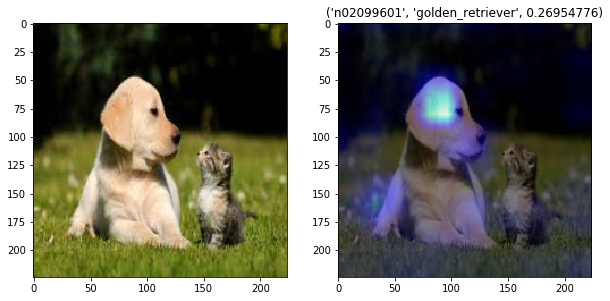

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(dog_image)

ax = fig.add_subplot(1,2,2)
ax.set_title(predicted_label[0])
ax.imshow(blended_image)
plt.show()

### (3) 레서 판다 시각화하기

In [20]:
prediction, heat_value = sess.run([y_pred, heat_map],
                      feed_dict={inputs:panda_image[np.newaxis]})
predicted_label = decode_predictions(prediction)[0]

blended_image = blend_heatmap(panda_image, heat_value)

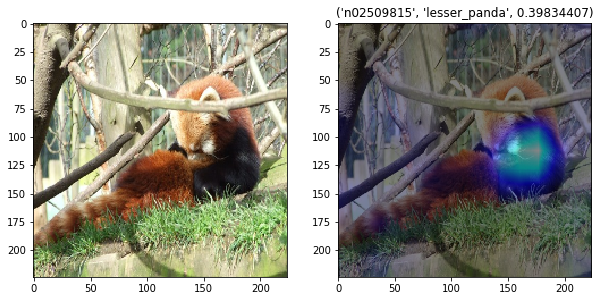

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(panda_image)

ax = fig.add_subplot(1,2,2)
ax.set_title(predicted_label[0])
ax.imshow(blended_image)
plt.show()

### reference : 

1. [Grad-CAM: Visual Explanations from deep networks via gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)
2. [Learning Deep Features for Discriminative Localization](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)